In [1]:
import json
import os

from typing import Annotated
from typing_extensions import TypedDict
from pydantic import BaseModel, Field
from langchain_groq import ChatGroq
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import Runnable, RunnableConfig
from langchain_core.tools import tool
from langchain_core.output_parsers import JsonOutputParser
from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.checkpoint.memory import MemorySaver
from dotenv import load_dotenv

In [2]:
load_dotenv()

os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")
os.environ["GOOGLE_API_KEY"] = os.getenv("GOOGLE_API_KEY")
os.environ["LANGCHAIN_TRACING_V2"] = os.getenv("LANGCHAIN_TRACING_V2")
os.environ["LANGCHAIN_API_KEY"] = os.getenv("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_PROJECT"] = os.getenv("LANGCHAIN_PROJECT")
os.environ["TAVILY_API_KEY"] = os.getenv("TAVILY_API_KEY")

In [3]:
class State(TypedDict):
    messages: Annotated[list, add_messages]
    title: str
    slide: int
    language: str

In [4]:
class Assistant:
    def __init__(self, runnable: Runnable):
        self.runnable = runnable

    def __call__(self, state: State, config: RunnableConfig):
        while True:
            result = self.runnable.invoke(state)
            # If the LLM happens to return an empty response, we will re-prompt it
            # for an actual response.
            if not result.tool_calls and (
                not result.content
                or isinstance(result.content, list)
                and not result.content[0].get("text")
            ):
                messages = state["messages"] + [("user", "Respond with a real output.")]
                state = {**state, "messages": messages}
            else:
                break
        return {"messages": result}

In [5]:
llm = ChatGroq(model="llama-3.3-70b-versatile")

In [6]:
tavily_tool = TavilySearchResults(max_results=5)

In [7]:
class Slide(BaseModel):
    title: str = Field(description="Title of Slide")
    content: str = Field(description="Concise yet impactful content that effectively covers the topic")

class Output(BaseModel):
    title: str = Field(description="Title of Presentation")
    slides: list[Slide] = Field(description="List of slides with content")

In [8]:
# Set up a parser + inject instructions into the prompt template.
parser = JsonOutputParser(pydantic_object=Output)

In [9]:
assistant_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are an AI assistant designed to help users create comprehensive PowerPoint presentations."
            "\n\nBased on the provided topic, automatically determine the appropriate slide structure, tone, and intended audience without asking the user."
            "\n\nEnsure the content is relevant, ethical, and aligns with the most suitable presentation style (e.g., educational, business pitch, or technical)."
            "\n\nRespond in the language specified in <language>. If the user requests a language other than English, generate the entire response in that language."
            "\n\nHere is the essential context for your operations:"
            "\n\n<title>\n{title}\n</title>"
            "\n\n<slide>\n{slide}\n</slide>"
            "\n\n<language>\n{language}\n</language>"
            "\n\nAlways confirm with the user before finalizing the content. Do not assume information if it's not provided—ask for clarification."
            "\n\nStrictly follow below formatting guidelines when generating a presentation's content:"
            "\n\n- Objective: Clearly define the purpose of the presentation.\n"
            "\n\n- Key Elements: Use bullet points to outline important details concisely.\n"
            "\n\n- Headings & Subheadings: Organize the content logically.\n"
            "\n\n- Minimal but Informative Text: Keep explanations brief yet meaningful.\n"
            "\n\nEnsure the content is engaging, easy to read, and leaves a lasting impression."
            "\n\nStrictly follow the response format below when generating a presentation:"
            "\n\nDo not provide slide number in the slide title."
            "\n\n{format_instructions}\n"
        ),
        ("placeholder", "{messages}")
    ]
).partial(format_instructions=parser.get_format_instructions())

In [10]:
assistant_runnable = assistant_prompt | llm.bind_tools([tavily_tool])

In [11]:
@tool
def fetch_config_info(config: RunnableConfig) -> dict:
    """
    Fetches the configuration values.
    args:
        config: RunnableConfig
    returns:
        dict: configuration values
    """
    configurable = config.get("configurable", {})
    return {
        "title": str(configurable.get("title") or ValueError("No title configured.")),
        "slide": int(configurable.get("slide") or ValueError("No slide number configured.")),
        "language": str(configurable.get("language") or ValueError("No language configured.")),
    }

In [12]:
def presentation_info(state: State):
    return fetch_config_info.invoke({})

In [13]:
graph_builder = StateGraph(State)

graph_builder.add_node("assistant", Assistant(assistant_runnable))

tool_node = ToolNode(tools=[tavily_tool])
graph_builder.add_node("tools", tool_node)
graph_builder.add_node("presentation_info", presentation_info)

graph_builder.add_conditional_edges(
    "assistant",
    tools_condition,
)

graph_builder.add_edge("tools", "assistant")
graph_builder.add_edge("presentation_info", "assistant")
graph_builder.set_entry_point("presentation_info")
graph = graph_builder.compile()

In [14]:
memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)

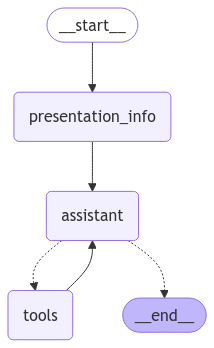

In [15]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [16]:
import uuid

thread_id = str(uuid.uuid4())

config = {"configurable": {"thread_id": thread_id, "title": "Introduction of machine learning", "slide": 10, "language": "en"}}

config

{'configurable': {'thread_id': '8dd0d9f9-a993-416a-ab19-54719c015a9c',
  'title': 'Introduction of machine learning',
  'slide': 10,
  'language': 'en'}}

In [17]:
events = graph.invoke(
    {"messages": ("user", "Generate a presesent")}, config, stream_mode="values"
)

In [18]:
response = events["messages"][-1].content

In [19]:
data = json.loads(response)

In [20]:
print("Title of Presentation:", data["title"])
for i in data["slides"]:
    print("Title of Slide:", i["title"])
    print(i["content"])
    print("")

Title of Presentation: Introduction to Machine Learning
Title of Slide: Introduction
Machine learning is a subset of artificial intelligence that involves the use of algorithms and statistical models to enable machines to perform a specific task without using explicit instructions, but rather by learning from data.

Title of Slide: Key Elements
Machine learning involves several key elements, including:
* Data collection and preprocessing
* Model selection and training
* Model evaluation and deployment
* Continuous learning and improvement

Title of Slide: Types of Machine Learning
There are several types of machine learning, including:
* Supervised learning
* Unsupervised learning
* Reinforcement learning
* Deep learning

Title of Slide: Applications of Machine Learning
Machine learning has numerous applications across various industries, including:
* Image and speech recognition
* Natural language processing
* Predictive maintenance
* Personalized recommendations

Title of Slide: Bene